In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets3')

In [5]:
import pyspark.sql.functions as F
df2 = df.select\
(['created_at', 'id_str', 'text', 'entities', 'user', 'retweeted_status', 'retweet_count', 'favorite_count', 'quote_count', 'lang',\
 F.col("user.screen_name").alias("name"), F.col("user.location").alias("location"), 
 F.col("user.favourites_count").alias('favorites_count2'),  F.col("user.followers_count").alias('followers_count2'),\
 F.col("user.statuses_count").alias('statuses_count2')])

In [6]:
df2 = df2.withColumn('verified', df2.user.verified)
df2 = df2.withColumn('description', df2.user.description)

In [7]:
df2 = df2.withColumn('description2', lower(df2.description))

In [8]:
df2 = df2.withColumn('organization', 
                F.when(df2.verified == 'false', 'Other') \
                .when( (df2.description2.contains('clinic')) \
                      | (df2.description2.contains('medic')) \
                      | (df2.description2.contains('nurse')) \
                      | (df2.description2.contains('health')) \
                      | (df2.description2.contains('doctor')) \
                      | (df2.description2.contains('md')), 'Health' ) \
                .when( (df2.description2.contains('democrat')) | (df2.description2.contains('republican')) | (df2.description2.contains('party')) \
                      | (df2.description2.contains('gov')) | (df2.description2.contains('senat')) \
                      | (df2.description2.contains('district')) | (df2.description2.contains('congress')) \
                      | (df2.description2.contains('chief')) | (df2.description2.contains('elect')), 'Governmental') \
                     .when(  (df2.description2.contains('news')) \
                      | (df2.description2.contains('journal')) | (df2.description2.contains('report')) | (df2.description2.contains('cover'))\
                                                                                                                          | (df2.description2.contains('times')) \
                                                                                                                          | (df2.description2.contains('post')) | (df2.description2.contains('magazine')) \
                                                                                                                          | (df2.description2.contains('station')) | (df2.description2.contains('tribune')) \
                                                                                                                          | (df2.description2.contains('pbs')) | (df2.description2.contains('insider')) \
                                                                                                                          | (df2.description2.contains('abc')) | (df2.description2.contains('media')) \
                                                                                                                          | (df2.description2.contains('gazette')) | (df2.description2.contains('edit')) \
                                                                                                                          | (df2.description2.contains('daily')) | (df2.description2.contains('column')), 'News')\
                     .when(df2.followers_count2 >= 30000, 'Celebrity').when(df2.followers_count2 >= 1000, 'Influencer')
                    
                ) 

In [9]:
df2 = df2.fillna({'organization' : 'Other'})

In [10]:
original_df = df2.filter(df2.retweeted_status.isNull())

In [12]:
#original_df

### Healthcare

In [13]:
df_news = original_df.filter(original_df.organization == 'Health')

In [14]:
df_text_raw = df_news.select(["text"])

In [16]:
df_news.count()

34941

In [17]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [18]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [19]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [20]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [26]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [27]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [28]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [30]:
df_dups_text.cache()

In [32]:
df_dups_30 = df_dups_text

In [31]:
records = 34941

In [33]:
dups = df_dups_text.select('id_A').distinct().count()

In [34]:
uniques = records - dups

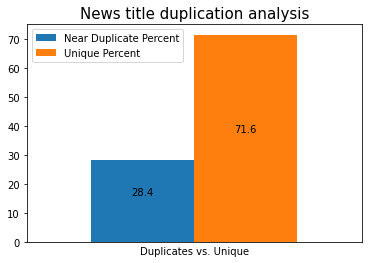

In [9]:
dups_df = pd.DataFrame.from_dict({'Near Duplicate Percent': [dups], 'Unique Percent': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['Near Duplicate Percent', 'Unique Percent'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
       ax.set_xticks([])

In [6]:
dups = 9915/(9915+25026)*100

In [7]:
uniques = 25026/(9915+25026)*100

In [5]:
uniques

0.7162359405855585

### Governmental

In [37]:
df_gov = original_df.filter(original_df.organization == 'Governmental')

In [38]:
df_text_raw1 = df_gov.select(["text"])

In [39]:
#df_gov.count()

In [40]:
text1 = df_text_raw1.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

Py4JJavaError: An error occurred while calling o567.javaToPython.
: java.util.NoSuchElementException: None.get
	at scala.None$.get(Option.scala:529)
	at scala.None$.get(Option.scala:527)
	at org.apache.spark.sql.execution.FileSourceScanExec.needsUnsafeRowConversion$lzycompute(DataSourceScanExec.scala:178)
	at org.apache.spark.sql.execution.FileSourceScanExec.needsUnsafeRowConversion(DataSourceScanExec.scala:176)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:463)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.FilterExec.doExecute(basicPhysicalOperators.scala:229)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.ProjectExec.doExecute(basicPhysicalOperators.scala:76)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:122)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:121)
	at org.apache.spark.sql.Dataset.javaToPython(Dataset.scala:3441)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
